# [Neural Style Transfer](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf) using  [Swift for TensorFlow](https://github.com/tensorflow/swift)

## What _is_ Neural Style Transfer?

Simply put, Neural Style Transfer [[Gatys et al.]](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf)  is a process by which we take the _style_ of one image, the _content_ of another image and generate a new image that exhibits the same stylistic features as the style image whilst preserving the high-level structure of the content image.

The neural part, as you might expect, is where the real magic happens. If you've read about or taken a course on Convolutional Neural Networks, you've probably encountered the wonderful paper [Visualizing and Understanding Convolutional Networks](http://openaccess.thecvf.com/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf) by Zeiler and Fergus. This paper keenly illustrates the fact that each kernel in a conv net acts as a sort of feature extractor. The features start out primitive and local but as the net goes deeper, the features become more abstract and global. Neural Style Transfer exploits this fact, extracting style information from the activations of various layers. We also extract _content_ information from the higher layers of the network. We use this information to compute what is referred to in the literature as the "Perceptual Loss".

Given an input image, our goal is to minimize Perceptual Loss with respect to that image. In order to compute the Perceptual Loss, we need the following:
* A style image
* A content image
* A styled image. This is the output. We can initialize it a number of ways (which we'll explore below).
* A way of extracting style information from layer activations. 
* A pretrained conv net (we'll use [VGG-19](https://arxiv.org/abs/1409.1556) [Karen Simonyan, Andrew Zisserman]).

<img src="StyleGraphic.jpg">

Attribution from left to right:

* King of Hearts / Wikimedia Commons / CC-BY-SA-3.0 [CC BY-SA 3.0 (https://creativecommons.org/licenses/by-sa/3.0)]
* A Starry Night by Vincent van Gogh, c. June 1889
* Image generated by employing the Neural Style Transfer algorithm [detailed by Gatys et al.](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf)

## Let's get started

You'll need the latest Swift for TensorFlow toolchain. See https://github.com/tensorflow/swift for installation instructions, etc. Also, Jeremy over at fast.ai wrote up a great [install guide](https://forums.fast.ai/t/jeremys-harebrained-install-guide/43814). **Note**: You'll probably need a relatively modern GPU to run this yourself. It should run on CPU, but it'll probably take forever.

### Install dependencies via SPM

In [3]:
%install-location $cwd/swift-install
%install '.package(url: "https://github.com/mxcl/Path.swift", from: "0.16.1")' Path
%install '.package(url: "https://github.com/JustHTTP/Just", from: "0.7.1")' Just

: 

### Import dependencies

In [7]:
import TensorFlow
import Python
import Path
import Just
import Foundation

A utility for loading VGG-19 weights from a checkpoint file.

In [8]:
 %include "CheckpointReader.swift"

Set up an extension on String that allows us to conveniently run shell commands via string literals! This is from the [fast.ai](fast.ai) swift [notebooks](https://github.com/fastai/fastai_docs/blob/master/dev_swift/00_load_data.ipynb). The downloadFile comes from there as well.

In [9]:
public extension String {
    @discardableResult
    func shell(_ args: String...) -> String
    {
        let (task,pipe) = (Process(),Pipe())
        task.executableURL = URL(fileURLWithPath: self)
        (task.arguments,task.standardOutput) = (args,pipe)
        do    { try task.run() }
        catch { print("Unexpected error: \(error).") }

        let data = pipe.fileHandleForReading.readDataToEndOfFile()
        return String(data: data, encoding: String.Encoding.utf8) ?? ""
    }
}

In [10]:
public func downloadFile(_ url: String, dest: String? = nil, force: Bool = false) {
    let dest_name = dest ?? (Path.cwd/url.split(separator: "/").last!).string
    let url_dest = URL(fileURLWithPath: (dest ?? (Path.cwd/url.split(separator: "/").last!).string))
    if !force && Path(dest_name)!.exists { return }

    print("Downloading \(url)...")

    if let cts = Just.get(url).content {
        do    {try cts.write(to: URL(fileURLWithPath:dest_name))}
        catch {print("Can't write to \(url_dest).\n\(error)")}
    } else {
        print("Can't reach \(url)")
    }
}

## Add a gram matrix method to `Tensor`

We use the gram matrix to extract the correlation structure between the filters of a given layer. This effectively allows us to decouple texture information from the global arrangement of the scene. We'll use this later when we calculate the perceptual loss.

In [3]:
public extension Tensor where Scalar: TensorFlowFloatingPoint {

    // Define the gram product.
    @differentiable
    func gramMatrix() -> Tensor<Scalar> {
        
        // Reshape to flatten the image dims to one dimension. Drop the batch dimension as well.
        let flatActivation = reshaped(to: TensorShape(shape[0], 
                                      shape[1] * shape[2], 
                                      shape[3])).squeezingShape(at: 0)
        
        // Take the matrix product of the transpose by the original. 
        return (flatActivation.transposed() • flatActivation) / Scalar(shape[1] * shape[2]) 
    }
}


## Define a layer for the input image

**Disclaimer:** This is probably not the best way to handle this, but after trying a few alternatives, I landed on this. The idea is that we want to freeze the parameters of the Conv Net and only update the input image during back prop. At the time of writing this, I couldn't find a straightforward way to **A)** freeze a layer while still computing gradients and **B)** have the input image be a tunable parameter. I have some ideas on how I might be able to better handle this, but this works well enough for now. 

In [4]:
// This layer allows us to update the input image during back propagation. 
// Probably not ideal. See above fore more info.
struct ImageTensorLayer: Layer {
    
    // This is the actual image that we'll be passing through the network.
    var imageTensor: Tensor<Float>
    
    init(imageTensor: Tensor<Float>) {
        self.imageTensor = imageTensor
    }
    
    // Note that this call ignores the input parameter and just passes imageTensor through.
    @differentiable
    func call(_ input: Tensor<Float>) -> Tensor<Float> {
        return self.imageTensor
    }
}

## Define a struct to store the output activations

At the time of writing this, arrays weren't differentiable. Swift for TensorFlow also doesn't currently support differentiable control flow which leads to more repititious code. It also doesn't support pulling activations out of a net after a forward pass. There are definitely work arounds for both of these issues but they involve writing a decent amount of code which would distract from the task at hand. At some point this functionality will probably be baked into the S4TF deep learning framework.

In [5]:
// This is used to store the output activations. These are used to compute the perceptual loss.
// As the property names suggest, we'll be using layers 1a, 2a, 3a, 4a and 5a for our style loss.
// and layers 4b and 5b for our content loss. 

struct OutputActivations: Differentiable {
    var activation1a: Tensor<Float>
    var style1a:      Tensor<Float>
    var activation2a: Tensor<Float>
    var style2a:      Tensor<Float>
    var activation3a: Tensor<Float>
    var style3a:      Tensor<Float>
    var activation4a: Tensor<Float>
    var style4a:      Tensor<Float>
    var activation4b: Tensor<Float>
    var activation5a: Tensor<Float>
    var style5a:      Tensor<Float>
    var activation5b: Tensor<Float>

    @differentiable
    init(activation1a: Tensor<Float>,
         activation2a: Tensor<Float>,
         activation3a: Tensor<Float>,
         activation4a: Tensor<Float>,
         activation4b: Tensor<Float>,
         activation5a: Tensor<Float>,
         activation5b: Tensor<Float>) {
        
        self.activation1a = activation1a
        self.style1a = activation1a.gramMatrix()
        
        self.activation2a = activation2a
        self.style2a = activation2a.gramMatrix()
        
        self.activation3a = activation3a
        self.style3a = activation3a.gramMatrix()
        
        self.activation4a = activation4a
        self.style4a = activation4a.gramMatrix()
        
        self.activation4b = activation4b
        
        self.activation5a = activation5a
        self.style5a = activation5a.gramMatrix()
        
        self.activation5b = activation5b
    }
}

## Define a concrete pooling type

We'll use this to easily swap which type of pooling we're using. Again, once differentiable control flow lands, this sort of thing shouldn't be necessary. I tried getting this to work nicely with generics but to no avail. I looked to the way activation functions were implemented to achieve this.

In [6]:
enum PoolingType{
    case max
    case avg
}

struct PoolingLayer<Scalar: TensorFlowFloatingPoint>: Layer {    
    
    public typealias PoolingOperation = @differentiable (Tensor<Scalar>) -> Tensor<Scalar>
    
    @noDerivative let poolingOperation: PoolingOperation

    init(poolingType: PoolingType, 
         poolSize: (Int, Int) = (2, 2), 
         strides: (Int, Int) = (2, 2), 
         padding: Padding = .valid) {
        
        switch poolingType {
            case .max:
                let maxPool = MaxPool2D<Scalar>(poolSize: poolSize, strides: strides, padding: padding)
                poolingOperation = { (input: Tensor<Scalar>) -> Tensor<Scalar> in 
                                        return maxPool(input)
                                   }
            case .avg:
                let avgPool = AvgPool2D<Scalar>(poolSize: poolSize, strides: strides, padding: padding)
                poolingOperation = { (input: Tensor<Scalar>) -> Tensor<Scalar> in 
                                        return avgPool(input)
                                   }
        }
    }
    
    
    @differentiable
    func call(_ input: Tensor<Scalar>) -> Tensor<Scalar> {
        return poolingOperation(input)
    }
}

## Implement VGG19 architecture without classification head

This code should look fairly straightforward. Again, I could probably reduce some of the repition but this is just a first pass on this to get something up and running. I may do an update where I go in and refactor some of this (especially once differentiable control flow is supported).

In [7]:
struct VGG19: Layer {
    var conv1a: Conv2D<Float>
    var conv1b: Conv2D<Float>
    
    var conv2a: Conv2D<Float>
    var conv2b: Conv2D<Float>
    
    var conv3a: Conv2D<Float>
    var conv3b: Conv2D<Float>
    var conv3c: Conv2D<Float>
    var conv3d: Conv2D<Float>
    
    var conv4a: Conv2D<Float>
    var conv4b: Conv2D<Float>
    var conv4c: Conv2D<Float>
    var conv4d: Conv2D<Float>
    
    var conv5a: Conv2D<Float>
    var conv5b: Conv2D<Float>
    var conv5c: Conv2D<Float>
    var conv5d: Conv2D<Float>
    
    // Default to max pooling
    var poolingLayer = PoolingLayer<Float>(poolingType: .max)
    
    init() {
        // CheckpointReader defines an extension that reads the weights and biases for a given conv layer.
        // I just threw CheckpointReader together for this notebook so it's not super reusable, but proper
        // model saving/loading/checkpointing is on the roadmap so it'll be easier to swap to that once it's
        // available.
        
        // Layer 1        
        self.conv1a = Conv2D(named: "block1_conv1")
        self.conv1b = Conv2D(named: "block1_conv2")
        
        // Layer 2
        self.conv2a = Conv2D(named: "block2_conv1")
        self.conv2b = Conv2D(named: "block2_conv2")
        
        // Layer 3
        self.conv3a = Conv2D(named: "block3_conv1")
        self.conv3b = Conv2D(named: "block3_conv2")
        self.conv3c = Conv2D(named: "block3_conv3")
        self.conv3d = Conv2D(named: "block3_conv4")
        
        // Layer 4
        self.conv4a = Conv2D(named: "block4_conv1")
        self.conv4b = Conv2D(named: "block4_conv2")
        self.conv4c = Conv2D(named: "block4_conv3")
        self.conv4d = Conv2D(named: "block4_conv4")
        
        // Layer 5
        self.conv5a = Conv2D(named: "block5_conv1")
        self.conv5b = Conv2D(named: "block5_conv2")
        self.conv5c = Conv2D(named: "block5_conv3")
        self.conv5d = Conv2D(named: "block5_conv4")
    }
    
    @differentiable
    func call(_ input: Tensor<Float>) -> OutputActivations {
        var tmp = input
        
        // Layer 1
        tmp = conv1a(tmp)
        let act1a = tmp
        tmp = conv1b(tmp)
        tmp = poolingLayer(tmp)
        
        // Layer 2 
        tmp = conv2a(tmp)
        let act2a = tmp
        tmp = conv2b(tmp)
        tmp = poolingLayer(tmp)
        
        // Layer 3
        tmp = conv3a(tmp)
        let act3a = tmp
        tmp = conv3b(tmp)
        tmp = conv3c(tmp)
        tmp = conv3d(tmp)
        tmp = poolingLayer(tmp)
        
        // Layer 4
        tmp = conv4a(tmp)
        let act4a = tmp
        tmp = conv4b(tmp)
        let act4b = tmp
        tmp = conv4c(tmp)
        tmp = conv4d(tmp)
        tmp = poolingLayer( tmp)
        
        // Layer 5
        tmp = conv5a(tmp)
        let act5a = tmp
        tmp = conv5b(tmp)
        let act5b = tmp
        tmp = conv5c(tmp)
        tmp = conv5d(tmp)
        tmp = poolingLayer(tmp)
        
        return OutputActivations(activation1a: act1a, 
                                 activation2a: act2a, 
                                 activation3a: act3a, 
                                 activation4a: act4a, 
                                 activation4b: act4b, 
                                 activation5a: act5a,
                                 activation5b: act5b)
    }
}

## Tie the two layers together

I chose to compose the two layers into one here. I had written this prior to S4TF 0.3 which I believe introduced a better way to sequence layers together. I'll probably revisit this also.

In [8]:
struct StyleTransferModel: Layer {
    var inputLayer: ImageTensorLayer
    var model: VGG19
    
    init(inputLayer: ImageTensorLayer, model: VGG19) {
        self.inputLayer = inputLayer
        self.model = model
    }
    
    @differentiable
    func call(_ input: Tensor<Float>) -> OutputActivations {
        let image = self.inputLayer(input)
        return model(image)
    }
}

## Define an optimizer

This is probably the hackiest part of this. I'm sure there's a way to use the existing Adam optimizer and freeze all the parameters in the network, updating only the image, however I couldn't figure it out and this worked. I'll definitely revisit this on my next pass.

This code is identical to the Adam definition in the S4TF Deep Learning library except for the fact that it breaks out of the for loop after updating the first differentiable variable. The first differentiable variable is the image.

In [9]:
func zeroTensor(tensor: Tensor<Float>) -> Tensor<Float> {
    return Tensor<Float>(zeros: tensor.shape)
}

/// Adam optimizer.
///
/// Reference: ["Adam - A Method for Stochastic Optimization"](
/// https://arxiv.org/abs/1412.6980v8)
public class ImageAdam<Model: Layer>: Optimizer
    where Model.AllDifferentiableVariables == Model.CotangentVector {
    /// The learning rate.
    public var learningRate: Float
    /// A coefficient used to calculate the first and second moments of
    /// gradients.
    public var beta1: Float
    /// A coefficient used to calculate the first and second moments of
    /// gradients.
    public var beta2: Float
    /// A small scalar added to the denominator to improve numerical stability.
    public var epsilon: Float
    /// The weight decay.
    public var decay: Float
    /// The current step.
    public var step: Int = 0
    /// The first moments of the weights.
    public var firstMoments: Model.AllDifferentiableVariables
    /// The second moments of the weights.
    public var secondMoments: Model.AllDifferentiableVariables

    public init(
        for model: __shared Model,
        learningRate: Float = 1e-3,
        beta1: Float = 0.9,
        beta2: Float = 0.999,
        epsilon: Float = 1e-8,
        decay: Float = 0
    ) {
        precondition(learningRate >= 0, "Learning rate must be non-negative")
        precondition(0 <= beta1 && beta1 <= 1, "Beta parameter must be between 0 and 1")
        precondition(0 <= beta2 && beta2 <= 1, "Beta parameter must be between 0 and 1")
        precondition(decay >= 0, "Weight decay must be non-negative")

        self.learningRate = learningRate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.decay = decay

        // Initialize first & second moments to be zeros of the same shape.
        // We can't use `Model.AllDifferentiableVariables.zero` due to the
        // interaction between Key Paths and Differentiable Arrays.
        firstMoments = model.allDifferentiableVariables
        secondMoments = model.allDifferentiableVariables
        for kp in firstMoments.recursivelyAllWritableKeyPaths(to: Tensor<Float>.self) {
            firstMoments[keyPath: kp] = zeroTensor(tensor: firstMoments[keyPath: kp])
            secondMoments[keyPath: kp] = zeroTensor(tensor: secondMoments[keyPath: kp])
        }
    }


    public func update(_ model: inout Model.AllDifferentiableVariables,
                       along direction: Model.AllDifferentiableVariables) {
        step += 1
        let learningRate = self.learningRate * 1 / (1 + decay * Float(step))
        let stepSize = learningRate * (sqrt(1 - pow(beta2, Float(step))) /
            (1 - pow(beta1, Float(step))))
        
        // Update Float Tensor variables.
        for kp in model.recursivelyAllWritableKeyPaths(to: Tensor<Float>.self) {
            firstMoments[keyPath: kp] =
                firstMoments[keyPath: kp] * beta1 + (1 - beta1) * direction[keyPath: kp]
            secondMoments[keyPath: kp] =
                secondMoments[keyPath: kp] * beta2 + (1 - beta2) *
                direction[keyPath: kp] * direction[keyPath: kp]
            model[keyPath: kp] -=
                stepSize * firstMoments[keyPath: kp] / (sqrt(secondMoments[keyPath: kp]) + epsilon)
            break
        }
    }
}

## Total variation loss

Total variation loss is a regularization technique that is commonly used to denoise images. Unfortunately this currently causes the GPU memory to grow unbounded and triggers an OOM error. There's probably a clever way to avoid this, but the results look pretty good without it. I've kept it here for reference--perhaps someone can spot what I'm doing wrong and let me know ;)

In [10]:
@differentiable
public func totalVariationLoss(imageTensor: Tensor<Float>) -> Tensor<Float> { 
    
    let rank = imageTensor.rank
    let shape = imageTensor.shape
        
    let diff1LowerUp = [0, 1, 0, 0]
    let diff1UpperUp = [1, shape[1], shape[2], shape[3]]
    
    let diff1LowerDown = [0, 0, 0, 0]
    let diff1UpperDown = [1, shape[1] - 1, shape[2], shape[3]]
    
    let diff2LowerUp = [0, 0, 1, 0]
    let diff2UpperUp = [1, shape[1], shape[2], shape[3]]
    
    let diff2LowerDown = [0, 0, 0, 0]
    let diff2UpperDown = [1, shape[1], shape[2] - 1, shape[3]]
    
    let pixelDiff1 = imageTensor.slice(lowerBounds: diff1LowerUp, upperBounds: diff1UpperUp)
                     - imageTensor.slice(lowerBounds: diff1LowerDown, upperBounds: diff1UpperDown)
    
    let pixelDiff2 = imageTensor.slice(lowerBounds: diff2LowerUp, upperBounds: diff2UpperUp)
                     - imageTensor.slice(lowerBounds: diff2LowerDown, upperBounds: diff2UpperDown)
    
    return (pixelDiff1 * pixelDiff1).mean() + (pixelDiff2 * pixelDiff2).mean()
}

## Perceptual Loss

This is the loss function we'll use. We compute the **mean squared error** (MSE) between the target content activations and the styled image. We then weigh them by the content weight. We then do the same for the style activation layers but instead of computing the MSE of the raw activations, we compute the MSE of the **gram matrix** of the activations. Each style layer loss is then scaled by its own weight. Lastly, every thing is summed up and returned as our final loss.

In [11]:
@differentiable(wrt: styledImageActivations)
func perceptualLoss(contentTargetActivations: OutputActivations, 
                    styleTargetActivations: OutputActivations,
                    styledImageActivations: OutputActivations,
                    contentWeights: [Float],
                    styleWeights: [Float]) -> Tensor<Float> {
    
    // Content Loss
    var loss = meanSquaredError(predicted: styledImageActivations.activation4b, 
                                expected: contentTargetActivations.activation4b) * contentWeights[0]
    
    loss = loss + meanSquaredError(predicted: styledImageActivations.activation5b, 
                                  expected: contentTargetActivations.activation5b) * contentWeights[1]
    
    // Style Loss
    loss = loss + meanSquaredError(predicted: styledImageActivations.style1a, 
                                   expected: styleTargetActivations.style1a) * styleWeights[0]
    
    loss = loss + meanSquaredError(predicted: styledImageActivations.style2a, 
                                   expected: styleTargetActivations.style2a) * styleWeights[1]
    
    loss = loss + meanSquaredError(predicted: styledImageActivations.style3a, 
                                   expected: styleTargetActivations.style3a) * styleWeights[2]
    
    loss = loss + meanSquaredError(predicted: styledImageActivations.style4a, 
                                   expected: styleTargetActivations.style4a) * styleWeights[3]
    
    loss = loss + meanSquaredError(predicted: styledImageActivations.style5a, 
                                   expected: styleTargetActivations.style5a) * styleWeights[4]
    
    return loss
}

## A clamping utility

This utility is used to keep the color values in the range that VGG19 expects to see, i.e. +/- the imagenet mean pixel values (in BGR). Without this, regions of the image would over excite the network causing clipped regions and aberrant noise. **Note:** It might be an interesting experiment to clamp these values with a smooth function instead of min/max. It might reduce noise a bit. 

In [12]:
func clamp(image: Tensor<Float>, to mean: Tensor<Float>) -> Tensor<Float> {
    let maxTensor = mean.broadcast(like: image)
    let minTensor = -maxTensor
    
    let clampedImage = max(min(image, maxTensor), minTensor)
    
    return clampedImage
}

## Use Python interoperability to show images via matplotlib

In [13]:
let np = Python.import("numpy")
let display = Python.import("IPython.display")

## Image processing utilities

These functions are used to load up the images into Float tensors and pre/post process them. This pretrained VGG-19 was trained on images in BGR channel order that were normalized by the imagenet mean. Note that they did not divide by the standard deviation so values be in the range of **`[-mean, mean]`**.

In [14]:
func loadImage(fileName: StringTensor) -> Tensor<UInt8> {
    let imageBytes: StringTensor = Raw.readFile(filename: fileName)
    return Raw.decodeJpeg(contents: imageBytes, dctMethod: "")
}

In [15]:
func centerCrop<Scalar: TensorFlowNumeric>(image: Tensor<Scalar>, size: Int32) -> Tensor<Float> {
    // Use Raw.cropAndResize() to crop a square of (size x size) from the center of the image.
    let rank = image.rank
    precondition(rank == 4, "Image must be of rank 4 but image is of rank \(rank).")
    let (height, width) = (Float(image.shape[rank - 3]), Float(image.shape[rank - 2]))
    
    precondition(width * height > Float(size * size), 
                 "Image of size: (\(height), \(width)) already smaller than \(size).")
    
    let verticalSpace: Float = (height - Float(size)) / Float(2.0)
    let horizontalSpace: Float = (width - Float(size)) / Float(2.0)
    
    let y2 = (height - verticalSpace) / Float(height - 1.0)
    let x2 = (width - horizontalSpace) / Float(width - 1.0)
    let y1 = verticalSpace / Float(height - 1.0)
    let x1 = horizontalSpace / Float(width - 1.0)
        
    let boxes = Tensor<Float>([y1, x1, y2, x2]).expandingShape(at: 0)
    let cropSize = Tensor<Int32>([size, size])
    
    return Raw.cropAndResize(image: image, 
                             boxes: boxes, 
                             boxInd: [0], 
                             cropSize: cropSize)    
}

In [16]:
enum ByteOrdering {
    case bgr
    case rgb
}

In [17]:
func preprocess(image: Tensor<UInt8>,
                size: Int32,
                inByteOrdering: ByteOrdering,
                outByteOrdering: ByteOrdering,
                meanToSubtract: Tensor<Float>) -> Tensor<Float> {
    
    let rank = image.rank
    let (height, width) = (Float(image.shape[rank - 3]), Float(image.shape[rank - 2]))
    
    var resizedImage = Tensor<Float>(image.expandingShape(at: 0))
    
    if width * height > Float(size * size) {
        resizedImage = centerCrop(image: resizedImage, size: size)
    } else {
        let sizeTensor = Tensor<Int32>([size, size])
        var resizedImage = Tensor<Float>(Raw.resizeNearestNeighbor(images: resizedImage, 
                                                                   size: sizeTensor))        
    }
        
    if inByteOrdering != outByteOrdering {
        resizedImage = Raw.reverse(resizedImage, dims: Tensor<Bool>([false, false, false, true]))
    }
    
    return resizedImage - meanToSubtract.expandingShape(at: 0)
}

func postprocess(image: Tensor<Float>,
                 inByteOrdering: ByteOrdering,
                 outByteOrdering: ByteOrdering, 
                 meanToAdd: Tensor<Float>) -> Tensor<UInt8> {

    var processedImage = image + meanToAdd
    
    if inByteOrdering != outByteOrdering {
        processedImage = Raw.reverse(processedImage, dims: Tensor<Bool>([false, false, false, true]))
    }

    return Tensor<UInt8>(processedImage).squeezingShape(at: 0)
}

## Set up matplotlib for inline display

In [18]:
// Setup.
%include "EnableIPythonDisplay.swift"
let plt = Python.import("matplotlib.pyplot")
IPythonDisplay.shell.enable_matplotlib("inline")

('inline', 'module://ipykernel.pylab.backend_inline')


In [19]:
let imageNetMean = Tensor<Float>([116.779, 103.939, 123.68])

## A utility to display the styled image

In [20]:
func showImageTensor(tensor: Tensor<Float>,
                     byteOrdering: ByteOrdering) {
    plt.figure(figsize: [5, 5])
    plt.axis("off")
    let pixelTensor = postprocess(image: tensor,
                                  inByteOrdering: byteOrdering, 
                                  outByteOrdering: .rgb, 
                                  meanToAdd: imageNetMean)
    plt.imshow(pixelTensor.makeNumpyArray())
    plt.show()
}

## Define a struct to hold the training results

This is where the results of training get stored so we can see how the training progressed over time. It also has a function that will plot the output images in a grid. This is nifty when trying out and comparing different hyper parameters.

In [21]:
struct StyleTransferResult: CustomStringConvertible {
    var outputImages: [Tensor<Float>] = []
    var losses: [Float] = []
    
    let styleWeights: [Float]
    let contentWeights: [Float]
    let lr: Float
    let iterations: Int
    let saveEvery: Int
    
    var description: String {
        let description = """
               contentWeights: \(contentWeights)\n 
               styleWeights: \(styleWeights)\n
               lr: \(lr)\n
               iterations: \(iterations)\n
               saveEvery: \(saveEvery)\n
               losses: \(losses)\n
               """
        return description
    }
    
    init(styleWeights: [Float], 
         contentWeights: [Float], 
         lr: Float, 
         iterations: Int,
         saveEvery: Int) {
        self.styleWeights = styleWeights
        self.contentWeights = contentWeights
        self.lr = lr
        self.iterations = iterations
        self.saveEvery = saveEvery
    }
    
    public func showImages() {
        let (rows, cols) = (Int(ceil(Float(outputImages.count) / Float(2.0))), 2)
        
        plt.figure(figsize: [24, 24])

        for i in 0..<(rows * cols) {
            if i  > outputImages.count - 1 {
                break
            }
            
            let img = plt.subplot(rows, cols, i + 1)
            img.axis("off")
            let pixelTensor = postprocess(image: outputImages[i],
                                          inByteOrdering: .bgr,
                                          outByteOrdering: .rgb,
                                          meanToAdd: imageNetMean)
            
            let x = pixelTensor.makeNumpyArray()
            img.imshow(x)
            img.set_title("Iteration: \(i * saveEvery)")
        }
        
        plt.show()        
    }
}


## Peek at the style and content images

We'll use the images from the graphic at the beginning of the post. **Note**: If you run into memory issues, you can drop the size down to 256. 

In [22]:
let contentImageBytes = loadImage(fileName:StringTensor("./painted_ladies.jpg"))
let contentImageTensor = preprocess(image: contentImageBytes, 
                                    size: 512, 
                                    inByteOrdering: .rgb, 
                                    outByteOrdering: .bgr,
                                    meanToSubtract: imageNetMean)

let styleImageBytes = loadImage(fileName:StringTensor("./vangogh_starry_night.jpg"))
let styleImageTensor = preprocess(image: styleImageBytes, 
                                  size: 512, 
                                  inByteOrdering: .rgb, 
                                  outByteOrdering: .bgr, 
                                  meanToSubtract: imageNetMean)

In [23]:
print(contentImageTensor.shape)
print(styleImageTensor.shape)

TensorShape(dimensions: [1, 512, 512, 3])
TensorShape(dimensions: [1, 512, 512, 3])


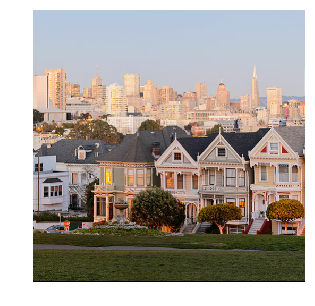

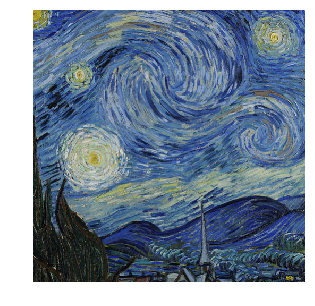

In [24]:
showImageTensor(tensor: contentImageTensor, byteOrdering: .bgr)
showImageTensor(tensor: styleImageTensor, byteOrdering: .bgr)

## Define the training method

Right now I've only really needed to change the style weights, content weight, iteration count and learning rate, so that's what's exposed. 

In [25]:
func train(model: inout StyleTransferModel,
           contentTarget: OutputActivations,
           styleTarget: OutputActivations,
           lr: Float, 
           iterations: Int = 450, 
           contentWeights: [Float],
           styleWeights: [Float],
           saveEvery: Int) -> StyleTransferResult {
    
    // Set up the optimizer
    let targetOptimizer = ImageAdam(for: model, learningRate: lr, beta1: 0.9, beta2: 0.999, epsilon: 1e-8)
    
    // Set up the result where we'll store training progress.
    var result = StyleTransferResult(styleWeights: styleWeights, 
                                     contentWeights: contentWeights, 
                                     lr: lr, 
                                     iterations: iterations,
                                     saveEvery: saveEvery)
    
    // Loop for the specified iterations.
    for i in 0..<iterations {
        
        // Keep track of the loss.
        var lastLoss: Float = 0.0
        
        // Compute the cotangent vector of the loss with respect to the styled image.
        let 𝛁model = model.gradient { model -> Tensor<Float> in
            
            // Run the forward pass for the model. 
            let styledImageActivations = model(model.inputLayer.imageTensor)
            // Compute the perceptual loss
            var loss = perceptualLoss(contentTargetActivations: contentTarget, 
                                      styleTargetActivations: styleTarget, 
                                      styledImageActivations: styledImageActivations,
                                      contentWeights: contentWeights,
                                      styleWeights: styleWeights)
                                      
            // Store the loss so we can track it outside of this closure.                                                                
            lastLoss = loss.scalarized()
                                      
            return loss
        }
        
        // Update the model along the cotangent vector
        targetOptimizer.update(&model.allDifferentiableVariables, along: 𝛁model)
        
        // Clamp the styled image to be in the range of [-mean, mean]. 
        model.inputLayer.imageTensor = clamp(image: model.inputLayer.imageTensor, to: imageNetMean)
        
        // Save the output image if necessary.
        if i % saveEvery == 0  {
            print("\t[Iteration \(i) - Perceptual Loss: \(lastLoss)]")
            result.outputImages.append(model.inputLayer.imageTensor)
            result.losses.append(lastLoss)
        } else if i == iterations - 1 {
            print("\t[Iteration \(iterations) - Perceptual Loss: \(lastLoss)]")
            result.outputImages.append(model.inputLayer.imageTensor)
            result.losses.append(lastLoss)
        }
    }
    
    return result
}

## Tie things up into a function we can experiment with

In [26]:
func styleTransfer(styleImagePath: String,
                   contentImagePath: String,
                   styledImage: Tensor<Float>? = nil,
                   imageSize: Int32 = 256,
                   poolingType: PoolingType = .max,
                   learningRate: Float = 4.0,
                   styleWeights: [Float],
                   contentWeights: [Float],
                   iterations: Int = 500,
                   saveEvery: Int = 50) -> StyleTransferResult {

    // Load up the specified style and content images.
    let contentImageBytes = loadImage(fileName:StringTensor(contentImagePath))
    let contentImageTensor = preprocess(image: contentImageBytes, 
                                        size: imageSize, 
                                        inByteOrdering: .rgb, 
                                        outByteOrdering: .bgr,
                                        meanToSubtract: imageNetMean)
    
    let styleImageBytes = loadImage(fileName:StringTensor(styleImagePath))
    let styleImageTensor = preprocess(image: styleImageBytes, 
                                      size: imageSize, 
                                      inByteOrdering: .rgb, 
                                      outByteOrdering: .bgr, 
                                      meanToSubtract: imageNetMean)
    
    // Set up the base VGG19 model
    var baseModel = VGG19()
    
    // Set the pooling type based on user preference.
    baseModel.poolingLayer = PoolingLayer(poolingType: poolingType)
    
    // Compute the target activations for the content and style.
    let contentTarget = baseModel.inferring(from: contentImageTensor)
    let styleTarget = baseModel.inferring(from: styleImageTensor)
    
    // If an initial styledImage was passed in, use it; otherwise use the content image.
    let styledImageTensor = styledImage ?? contentImageTensor
    
    // Set up the net for optimizing the styled image.
    let styledInputLayer = ImageTensorLayer(imageTensor: styledImageTensor)
    var styleTransferModel = StyleTransferModel(inputLayer: styledInputLayer, model: baseModel)
    
    // Optimize the image!
    return train(model: &styleTransferModel,
                 contentTarget: contentTarget,
                 styleTarget: styleTarget,
                 lr: learningRate, 
                 iterations: iterations,
                 contentWeights: contentWeights,
                 styleWeights: styleWeights,
                 saveEvery: saveEvery)
}

## Let's finally perform style transfer to make an image 

In [27]:
// Keep an array of results for comparison
var results: [StyleTransferResult] = []

We'll just use most of the default params for the style transfer function.

	[Iteration 0 - Perceptual Loss: 2.778563e+08]
	[Iteration 50 - Perceptual Loss: 4115679.0]
	[Iteration 100 - Perceptual Loss: 2275380.0]
	[Iteration 150 - Perceptual Loss: 1557564.1]
	[Iteration 200 - Perceptual Loss: 1184135.4]
	[Iteration 250 - Perceptual Loss: 1004197.25]
	[Iteration 300 - Perceptual Loss: 860276.44]
	[Iteration 350 - Perceptual Loss: 974759.9]
	[Iteration 400 - Perceptual Loss: 724243.5]
	[Iteration 450 - Perceptual Loss: 674475.75]
	[Iteration 500 - Perceptual Loss: 651596.44]


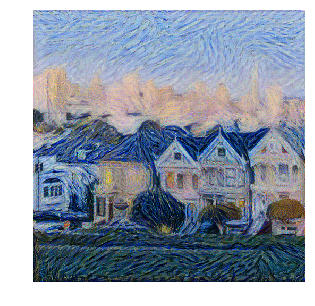

In [28]:
let styleWeights = [Float(1e3 / Float(pow(64.0 , 2.0))),
                    Float(1e3 / Float(pow(128.0, 2.0))),
                    Float(1e3 / Float(pow(256.0, 2.0))),
                    Float(1e3 / Float(pow(512.0, 2.0))),
                    Float(1e3 / Float(pow(512.0, 2.0)))]

let contentWeights:[Float] = [1.0, 1.0]

let result = styleTransfer(styleImagePath: "./vangogh_starry_night.jpg",
                           contentImagePath: "./painted_ladies.jpg", 
                           imageSize: 512,
                           styleWeights: styleWeights,
                           contentWeights: contentWeights)

results.append(result)

// Look at the last image.
showImageTensor(tensor: result.outputImages.last!, byteOrdering: .bgr)

Pretty cool, huh? The original paper uses [L-BFGS](https://en.wikipedia.org/wiki/Limited-memory_BFGS) which is a pretty memory intensive optimization algorithm (at least compared to standard NN optimzation algorithms like Adam). L-BFGS tends to produce better results, but I think this looks pretty good. Of couse we'd need to try it on more than one style/content pair to make a fair assessment.

## Let's look at how things progressed over time

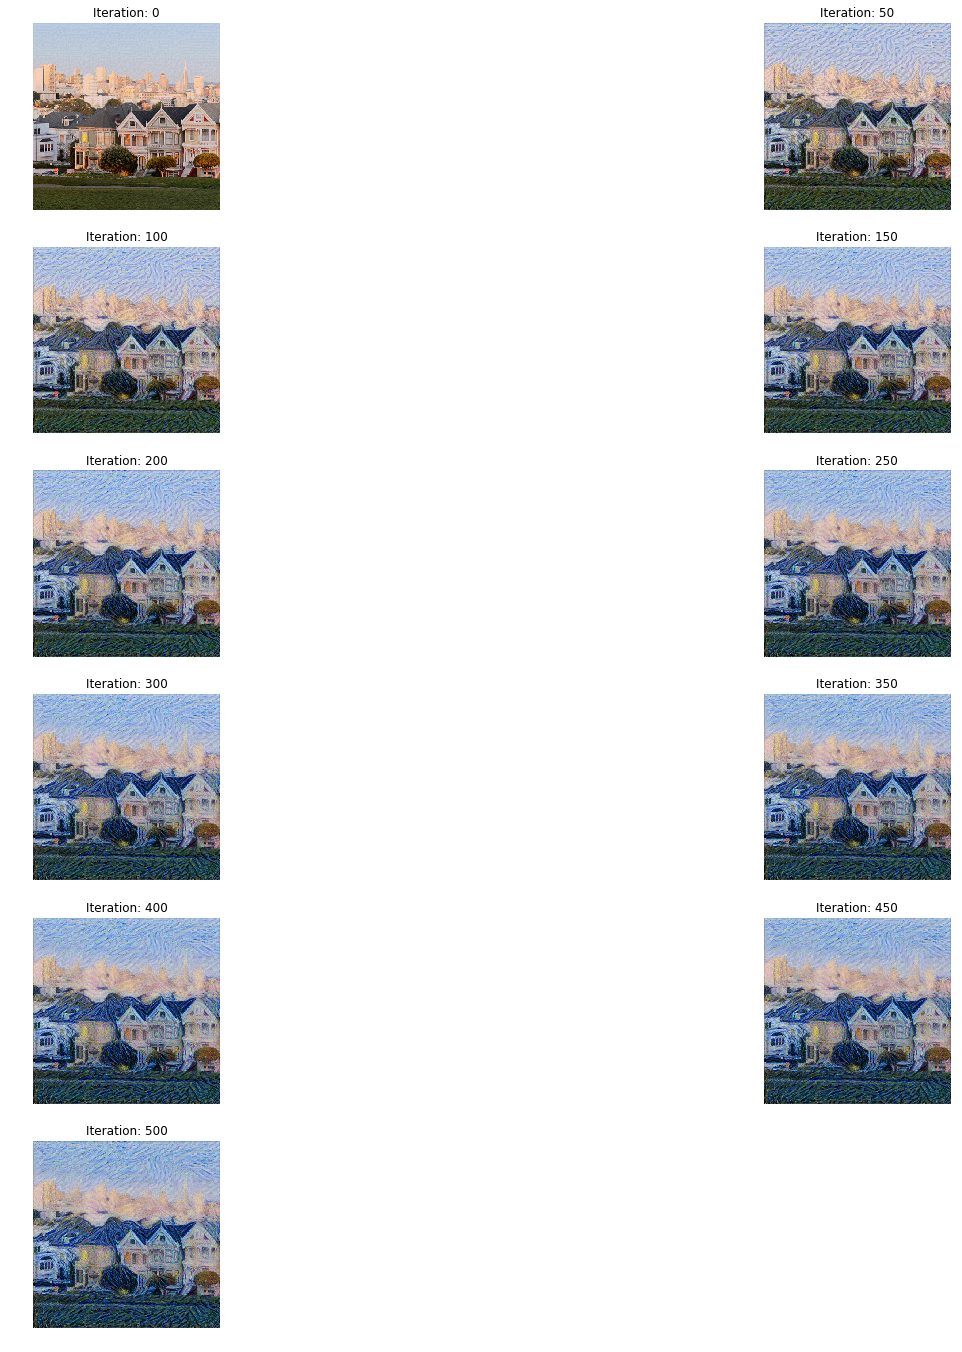

In [29]:
result.showImages()

## Let's look at the results

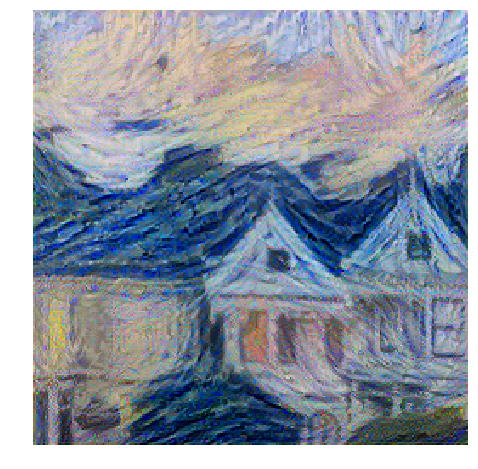

In [40]:
let result = results.last!.outputImages.last!
showImageTensor(tensor: result, byteOrdering: .bgr)

## Now let's try initializing with the style image instead

In [32]:
let styledImageTensor = preprocess(image: styleImageBytes, 
                                    size: 512, 
                                    inByteOrdering: .rgb, 
                                    outByteOrdering: .bgr,
                                    meanToSubtract: imageNetMean)

let styledInputLayer = ImageTensorLayer(imageTensor: styledImageTensor)
var styledLossNet = LossNet(inputLayer: styledInputLayer, model: baseModel)

// Let's bump up the content weight since the style features are already well represented.
let contentWeight:Float = 15.0

results.append(train(model: &styledLossNet, 
                     contentTarget: contentTargetActivations,
                     styleTarget: styleTargetActivations,
                     lr: lr, 
                     iterations: iterations,
                     contentWeight: contentWeight,
                     styleWeights: styleWeights,
                     saveEvery: 100))

[Iteration 0 - Perceptual Loss: 9576832.0]
[Iteration 100 - Perceptual Loss: 5514841.0]
[Iteration 200 - Perceptual Loss: 4697941.0]
[Iteration 300 - Perceptual Loss: 4477566.0]
[Iteration 400 - Perceptual Loss: 4297037.5]
[Iteration 500 - Perceptual Loss: 4138277.0]


## Compare the results

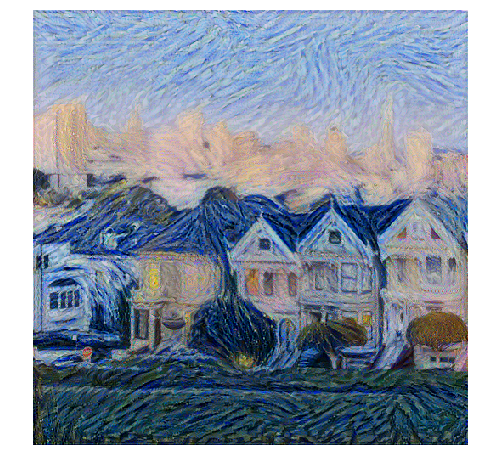

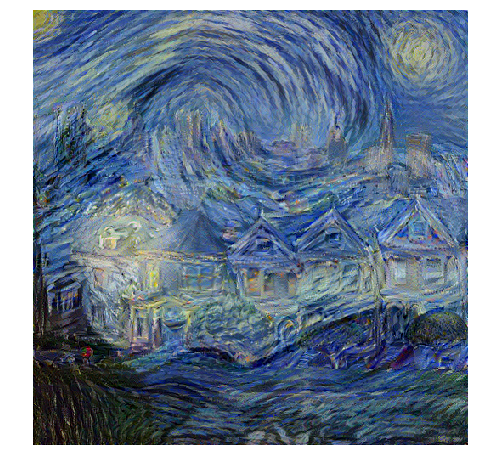

In [33]:
for result in results {
    showImageTensor(tensor: result.outputImages.last!, 
                    byteOrdering: .bgr)
}

You can see that a lot more of the global structure of the style image remains present. We could tune the style weights for the higher layers down a bit more or increase the content weight to achieve something closer to the first image.

## What if we init by mixing them? 

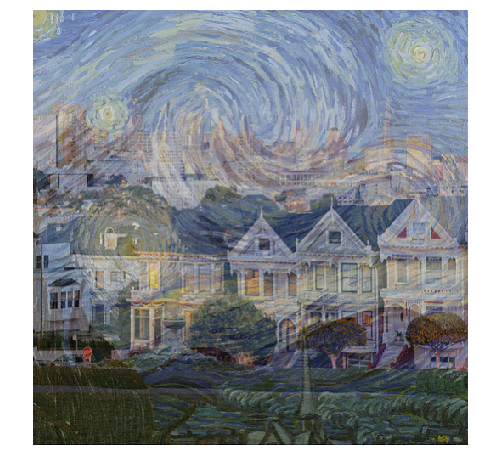

In [34]:
let styledImageTensor = (contentImageTensor + styleImageTensor) / 2.0
showImageTensor(tensor: styledImageTensor, byteOrdering: .bgr)

In [35]:
let styledInputLayer = ImageTensorLayer(imageTensor: styledImageTensor)
var styledLossNet = LossNet(inputLayer: styledInputLayer, model: baseModel)

// Let's bump up the content weight since the style features are already well represented.
let contentWeight:Float = 15.0

results.append(train(model: &styledLossNet,
                     contentTarget: contentTargetActivations,
                     styleTarget: styleTargetActivations,
                     lr: lr, 
                     iterations: iterations,
                     contentWeight: contentWeight,
                     styleWeights: styleWeights,
                     saveEvery: 100))

[Iteration 0 - Perceptual Loss: 1.2844255e+08]
[Iteration 100 - Perceptual Loss: 5060567.0]
[Iteration 200 - Perceptual Loss: 4382186.0]
[Iteration 300 - Perceptual Loss: 4143077.8]
[Iteration 400 - Perceptual Loss: 4070995.0]
[Iteration 500 - Perceptual Loss: 3934565.8]


## Let's compare all three

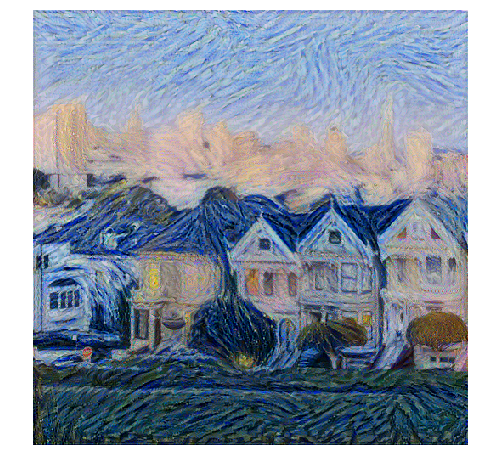

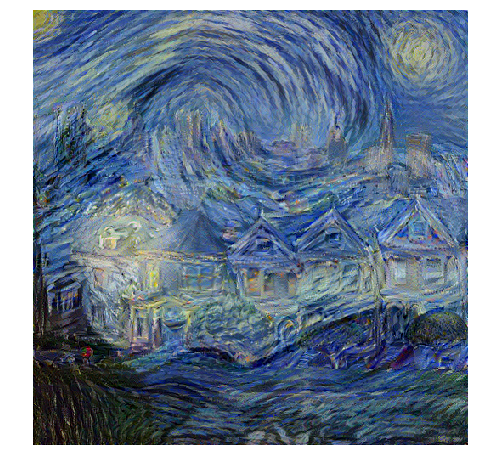

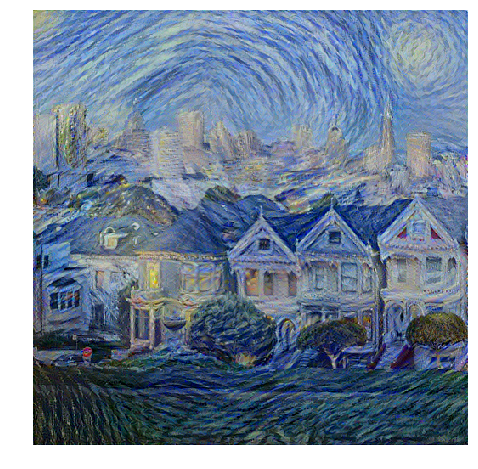

In [36]:
for result in results {
    showImageTensor(tensor: result.outputImages.last!, 
                    byteOrdering: .bgr)
}

## Let's use average pooling instead of max pooling

In [40]:
baseModel.poolingLayer = PoolingLayer<Float>(poolingType: .avg)

var contentLossNet = LossNet(inputLayer: contentInputLayer, model: baseModel)
var styleLossNet = LossNet(inputLayer: styleInputLayer, model: baseModel)

// Recompute the content activations
let contentTargetActivations = contentLossNet.inferring(from: contentImageTensor)

// Recompute the style activations
let styleTargetActivations = styleLossNet.inferring(from: styleImageTensor)

let styledImageTensor = preprocess(image: contentImageBytes, 
                                    size: 512, 
                                    inByteOrdering: .rgb, 
                                    outByteOrdering: .bgr,
                                    meanToSubtract: imageNetMean)

let styledInputLayer = ImageTensorLayer(imageTensor: styledImageTensor)
var styledLossNet = LossNet(inputLayer: styledInputLayer, model: baseModel)

let contentWeight:Float = 1.0

results.append(train(model: &styledLossNet,
                     contentTarget: contentTargetActivations,
                     styleTarget: styleTargetActivations,
                     lr: lr, 
                     iterations: iterations,
                     contentWeight: contentWeight,
                     styleWeights: styleWeights,
                     saveEvery: 100))

[Iteration 0 - Perceptual Loss: 10037819.0]
[Iteration 100 - Perceptual Loss: 127452.336]
[Iteration 200 - Perceptual Loss: 78315.81]
[Iteration 300 - Perceptual Loss: 64532.977]
[Iteration 400 - Perceptual Loss: 58422.39]
[Iteration 500 - Perceptual Loss: 54991.71]


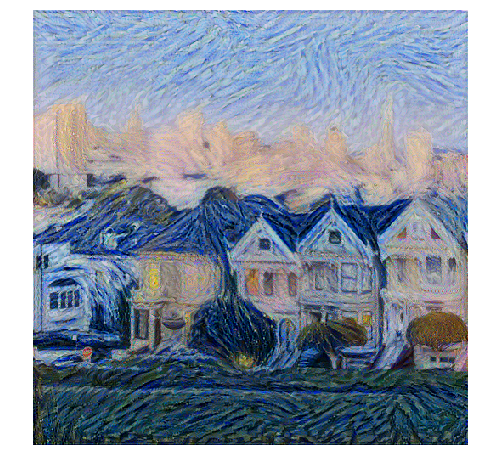

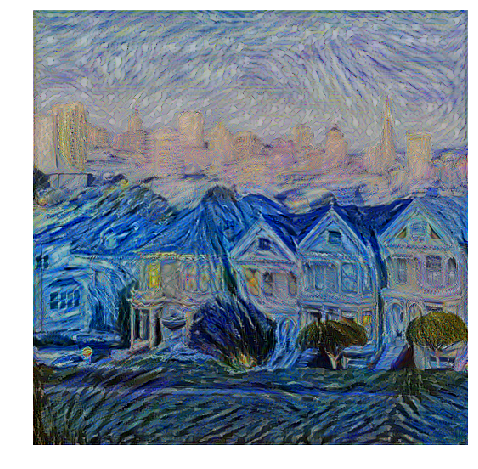

In [42]:
let firstImage = results.first!.outputImages.last!
let lastImage = results.last!.outputImages.last!

showImageTensor(tensor: firstImage, byteOrdering: .bgr)
showImageTensor(tensor: lastImage, byteOrdering: .bgr)
